# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

In [42]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1.Define the model class.

In [43]:
class MLP(nn.Module):

    def __init__(self, no_features, no_hidden, no_labels):
        super(MLP, self).__init__()
        self.mlp_stack = nn.Sequential(
            # YOUR CODE HERE
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),                          # ReLU activation
            nn.Dropout(0.2),                    # Dropout with probability 0.2

            nn.Linear(no_hidden, 128),          # First hidden layer to second hidden layer
            nn.ReLU(),                          # ReLU activation
            nn.Dropout(0.2),                    # Dropout with probability 0.2

            nn.Linear(128, 128),                # Second hidden layer to third hidden layer
            nn.ReLU(),                          # ReLU activation
            nn.Dropout(0.2),                    # Dropout with probability 0.2

            nn.Linear(128, no_labels),          # Third hidden layer to output layer
            nn.Sigmoid()
        )

    # YOUR CODE HERE
    def forward(self, x):
        # Define forward pass of the neural network
        return self.mlp_stack(x)

#### Divide the dataset into a 80:20 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

2.Split the dataset and do preprocessing.

In [44]:
df = pd.read_csv('simplified.csv')
df

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,-10.669799,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,-5.666375,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,-5.502390,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,-8.812989,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,-6.584204,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12052,app_3057_4113_phnd_pos_0022.wav,86.132812,1605,160.500000,0.549566,0.078633,0.438854,0.078327,0.258500,0.016511,...,-12.779257,67.892044,3.546391,49.891026,-3.597707,70.953079,-2.672421,62.369473,-3.812236,47.410625
12053,app_3057_4113_phnd_pos_0023.wav,184.570312,3037,168.722222,0.584372,0.074350,0.478900,0.078894,0.258216,0.016658,...,-9.979423,63.430107,3.869859,52.517521,-1.637068,59.811417,-3.041467,55.640205,-5.101839,43.080894
12054,app_3057_4113_phnd_pos_0024.wav,143.554688,1549,129.083333,0.541845,0.088258,0.441677,0.080670,0.261484,0.014959,...,-11.238145,79.961853,3.689087,68.597672,-1.665412,70.761398,0.218386,86.220604,-4.678007,85.629585
12055,app_3057_4113_phnd_pos_0025.wav,143.554688,8820,284.516129,0.532886,0.089102,0.469113,0.077342,0.265298,0.012950,...,-10.302938,80.636742,2.619849,63.592182,-0.559597,62.905022,0.256377,56.687534,-3.086725,62.594326


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12057 entries, 0 to 12056
Data columns (total 78 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   filename             12057 non-null  object 
 1   tempo                12057 non-null  float64
 2   total_beats          12057 non-null  int64  
 3   average_beats        12057 non-null  float64
 4   chroma_stft_mean     12057 non-null  float64
 5   chroma_stft_var      12057 non-null  float64
 6   chroma_cq_mean       12057 non-null  float64
 7   chroma_cq_var        12057 non-null  float64
 8   chroma_cens_mean     12057 non-null  float64
 9   chroma_cens_var      12057 non-null  float64
 10  melspectrogram_mean  12057 non-null  float64
 11  melspectrogram_var   12057 non-null  float64
 12  mfcc_mean            12057 non-null  float64
 13  mfcc_var             12057 non-null  float64
 14  mfcc_delta_mean      12057 non-null  float64
 15  mfcc_delta_var       12057 non-null 

In [46]:
from common_utils import split_dataset, preprocess_dataset
columns_to_drop = ['filename', 'label']

def preprocess(df):
    # YOUR CODE HERE
    # Split the dataset into training (80%) and testing (20%) sets
    # Accompanied with encoding the labels from 0 to n_classes-1 
    X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size, random_state)
    
    # Scale and prepare testing data
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()
test_size = 0.2 
random_state = 42
X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

In [47]:
print(X_train_scaled.shape, y_train.shape)
print(X_test_scaled.shape, y_test.shape)

(9645, 77) (9645,)
(2412, 77) (2412,)


In [48]:
df['label'].value_counts()

label
1    6202
0    5855
Name: count, dtype: int64

#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **3**.

3.Define a Pytorch Dataset and Dataloaders.  

In [49]:
class CustomDataset(Dataset):
    # YOUR CODE HERE
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X) 
        self.y = torch.LongTensor(y)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_sample = self.X[idx]
        y_sample = self.y[idx]
        return x_sample, y_sample


def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    # YOUR CODE HERE
    train_dataset = CustomDataset(X_train_scaled, y_train)
    test_dataset = CustomDataset(X_test_scaled, y_test)
    
    # Creating Dataloader
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader

batch_size = 128
train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

4.Next, define the model, optimizer and loss function.

In [50]:
# YOUR CODE HERE
no_features = X_train_scaled.shape[1]
no_hidden = 128
no_labels = 2
learning_rate = 0.001


In [51]:
model = MLP(no_features, no_hidden, no_labels)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
print(model)

MLP(
  (mlp_stack): Sequential(
    (0): Linear(in_features=77, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=2, bias=True)
    (10): Sigmoid()
  )
)


5.Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [52]:
# YOUR CODE HERE
from common_utils import EarlyStopper
from sklearn.metrics import accuracy_score

# Training loop
epochs = 100
early_stopper = EarlyStopper(patience=3, min_delta=0) # Patience set to 3

# Lists to store training information for plotting
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == labels).sum().item()
    
    average_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_train / len(train_dataloader.dataset)
    
    model.eval()
    total_loss = 0
    correct_test = 0
    
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_test += (predicted == labels).sum().item()
        
        average_validation_loss = total_loss / len(test_dataloader)
        test_accuracy = correct_test / len(test_dataloader.dataset)
        
    # Append information for plotting
    train_losses.append(average_train_loss)
    test_losses.append(average_validation_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    # Print train and test accuracies for each epoch
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {average_validation_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    
    # Check for early stopping
    if early_stopper.early_stop(average_validation_loss):
        print('Early stopping triggered.')
        break

Epoch 1/100, Train Loss: 0.6845, Train Accuracy: 0.5530, Test Loss: 0.6756, Test Accuracy: 0.5792
Epoch 2/100, Train Loss: 0.6699, Train Accuracy: 0.5888, Test Loss: 0.6625, Test Accuracy: 0.6020
Epoch 3/100, Train Loss: 0.6538, Train Accuracy: 0.6175, Test Loss: 0.6498, Test Accuracy: 0.6281
Epoch 4/100, Train Loss: 0.6421, Train Accuracy: 0.6369, Test Loss: 0.6372, Test Accuracy: 0.6426
Epoch 5/100, Train Loss: 0.6304, Train Accuracy: 0.6541, Test Loss: 0.6274, Test Accuracy: 0.6633
Epoch 6/100, Train Loss: 0.6181, Train Accuracy: 0.6705, Test Loss: 0.6249, Test Accuracy: 0.6592
Epoch 7/100, Train Loss: 0.6067, Train Accuracy: 0.6844, Test Loss: 0.6161, Test Accuracy: 0.6729
Epoch 8/100, Train Loss: 0.5997, Train Accuracy: 0.6900, Test Loss: 0.6112, Test Accuracy: 0.6704
Epoch 9/100, Train Loss: 0.5882, Train Accuracy: 0.7059, Test Loss: 0.6010, Test Accuracy: 0.6895
Epoch 10/100, Train Loss: 0.5824, Train Accuracy: 0.7114, Test Loss: 0.6054, Test Accuracy: 0.6866
Epoch 11/100, Train

#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


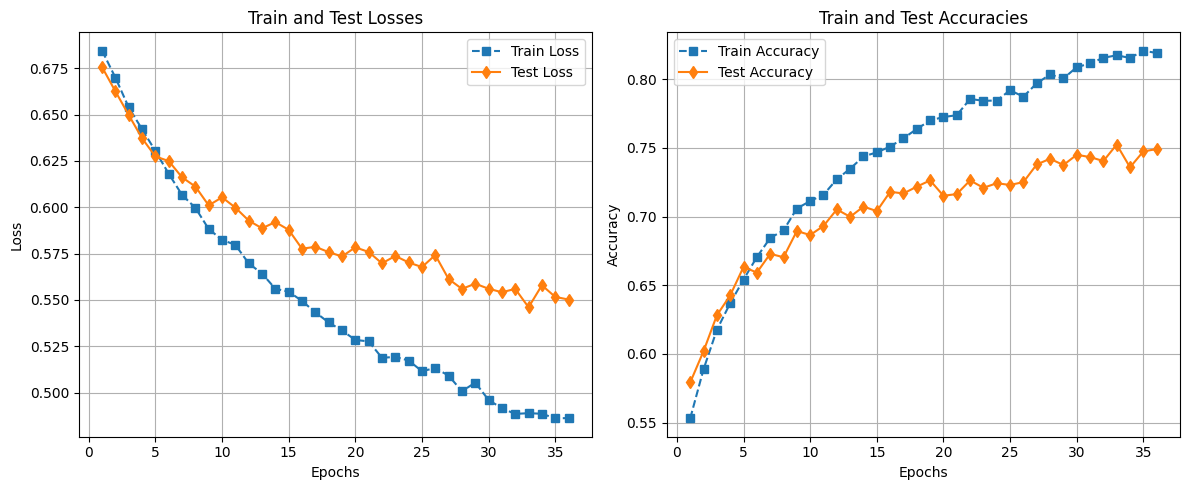

In [53]:
# Plot losses and accuracies with enhanced visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot losses
axes[0].plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', linestyle='--', marker='s')
axes[0].plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', linestyle='-', marker='d')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Train and Test Losses')
axes[0].legend()
axes[0].grid(True)

# Plot accuracies
axes[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', linestyle='--', marker='s')
axes[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy', linestyle='-', marker='d')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Train and Test Accuracies')
axes[1].legend()
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


6.Comment on line plots.

In [54]:
# YOUR CODE HERE
answer = """
Train + Test Losses
1. As training progresses, and no of traing epochs increases the train loss typically decreases, signaling the model is learning from the data.

2. Test loss also drops initially but may level off or increase after some epochs, indicating possible overfitting if it diverges significantly from train loss.

Train + Test Accuracy

1. Train accuracy generally increases over epochs, showing improved model fit on training data.

2. The test accuracy plot shows how well the model generalizes to unseen data. Test accuracy rises initially but may plateau or fall, ndicating reduced generalization if the model starts overfitting.

"""